In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="nn_refpoints_normalizedX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b9996bea2e77a10fd1fd092fcfeecea NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

### Tying down "true" latent variables:

In [4]:
n_ref = 100
ref_points = npr.choice(Nobs,n_ref,replace=False)
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = X[:,ref_points]
Y_train = Y[:,train]

In [5]:
np.shape(X_ref)

(2, 100)

In [6]:
for i in range(np.shape(X)[0]) :
    X_ref[i] /= (Nobs/n_ref)*np.linalg.norm(X_ref[i])

<IPython.core.display.Javascript object>


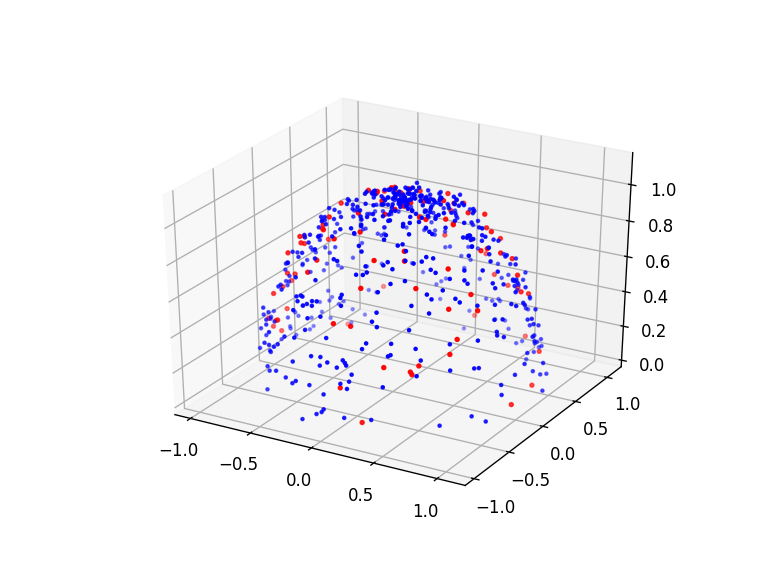

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Y_train[0], ys=Y_train[1], zs=Y_train[2], zdir='z', s=3, c=None, depthshade=True, color="blue")
ax.scatter(xs=Y_ref[0], ys=Y_ref[1], zs=Y_ref[2], zdir='z', s=5, c=None, depthshade=True, color="red")
plt.show()

In [7]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=50,
                      n_ref=n_ref,
                      y=Y_train.transpose(), 
                      y_ref=Y_ref.transpose(),
                      X_ref=X_ref.transpose())

In [ ]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

In [ ]:
trace = fit_refpoints.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

In [ ]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

In [ ]:
plt.plot(pw_dist_matrix[9,5]);

In [ ]:
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            plt.subplot(10,10,10*i+j+1)
            plt.plot(pw_dist_matrix_lle[i,j])
            plt.xticks([])
            plt.yticks([])
plt.show()